In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sys
sys.path.append('./zdrojaky')
from tsplot import tsplot
from statsmodels import tsa
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.api import qqplot
from IPython.display import display, Markdown
from statsmodels.tsa.seasonal import seasonal_decompose

# Four-weekly totals of beer shipments
Čtyřtýdení součty objednávek piva. Rok neznámý, proto jako pravděpodobný rok byl zvolen rok 1970.

In [110]:
df = pd.read_csv('fourweekly-totals-of-beer-shipme.csv')
df.info()

fn = 'fourweekly-totals-of-beer-shipme.csv'
# Vyberu z datasetu pouze součtu objednávek v jednotlivých týdnech
data = df['Four-weekly totals of beer shipments'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
Week                                    52 non-null object
Four-weekly totals of beer shipments    52 non-null int64
dtypes: int64(1), object(1)
memory usage: 912.0+ bytes


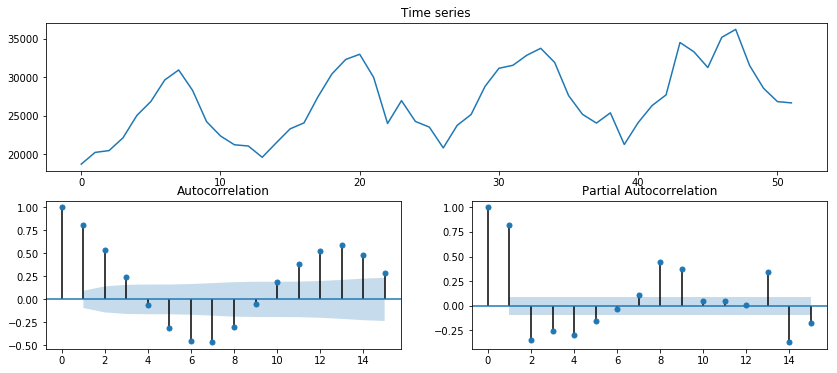

In [112]:
tsplot(data)

Časová řada představuje prodeje piva za 4 roky vždy po čtyřtýdenních součtech.
Při pohledu na časovou řadu je patrná sezónost, která se dala očekávat.
Nárůst objednávek přes letní měsíce, kdy se určitě více pije pivo.

Dále méně patrný je trend. V těchto 4 letech počet objednávek narůstal.


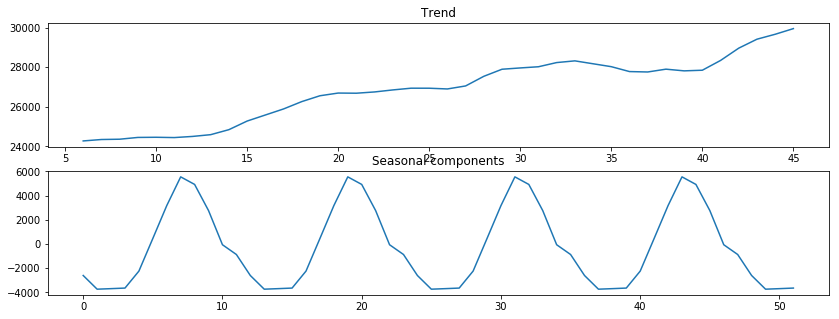

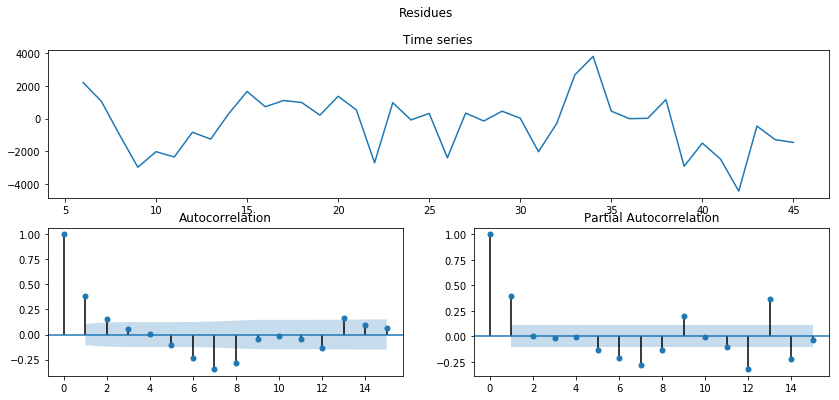

In [76]:
result = seasonal_decompose(df['Four-weekly totals of beer shipments'], freq=12, model='aditive')
plt.figure(figsize=(14,5))
plt.subplot(2,1,1)
plt.plot(result.trend)
plt.title("Trend")
plt.subplot(2,1,2)
plt.plot(result.seasonal)
plt.title("Seasonal components")
tsplot(result.resid.dropna())
plt.suptitle("Residues")
plt.show()

In [ ]:
# jak jsem spocital sezony a proc jsem svolil derivace

In [218]:
model = SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,0,13))
result = model.fit()
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   52
Model:             SARIMAX(0, 1, 1)x(0, 1, 0, 13)   Log Likelihood                -341.743
Date:                            Tue, 18 Dec 2018   AIC                            687.486
Time:                                    17:33:36   BIC                            690.762
Sample:                                         0   HQIC                           688.652
                                             - 52                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2582      0.080     -3.215      0.001      -0.416      -0.101
sigma2       3.55e+06   7.64e+05   

<Figure size 1080x216 with 0 Axes>

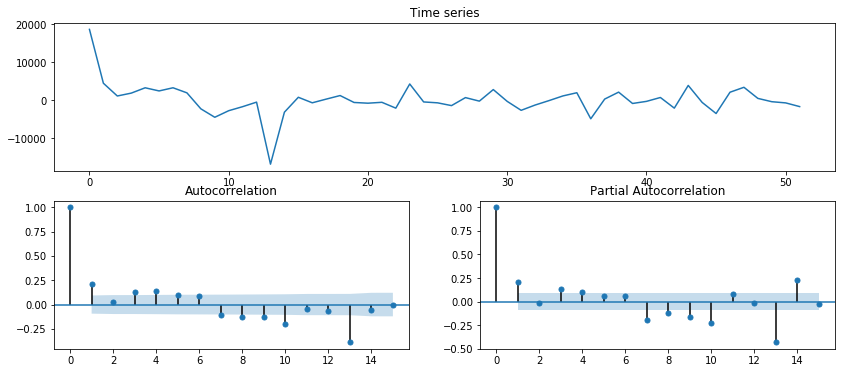

In [219]:
plt.figure(figsize=(15,3))
tsplot(result.resid)
plt.show()

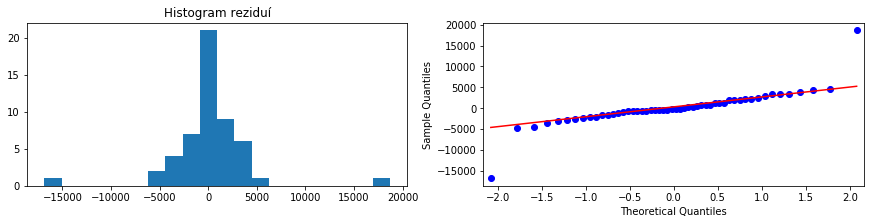

In [220]:
plt.figure(figsize=(15,3))
ax = plt.subplot(1,2,1)
plt.hist(result.resid, bins=20)
plt.title('Histogram reziduí')
ax = plt.subplot(1,2,2)
qqplot(result.resid, line='q', ax=ax)
plt.show()

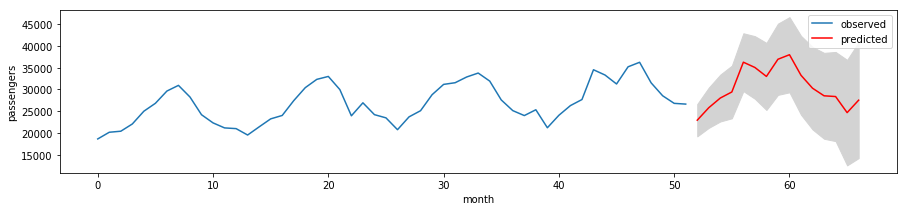

In [223]:
nsteps = 15
forecast = result.get_forecast(steps=nsteps)
plt.figure(figsize=(15,3))
plt.plot(np.arange(data.size), data, label='observed')
plt.plot(np.arange(data.size, data.size+forecast.predicted_mean.size), 
         forecast.predicted_mean, 'r', label='predicted')
plt.fill_between(np.arange(data.size, data.size+forecast.predicted_mean.size), 
                 forecast.summary_frame()['mean_ci_lower'],
                 forecast.summary_frame()['mean_ci_upper'],
                 color='lightgray')
plt.legend()
plt.xlabel('month')
plt.ylabel('passengers')
plt.show()

Zdroj dat: <https://datamarket.com/data/set/2325/four-weekly-totals-of-beer-shipments#!ds=2325&display=line>